### Actor-Critic
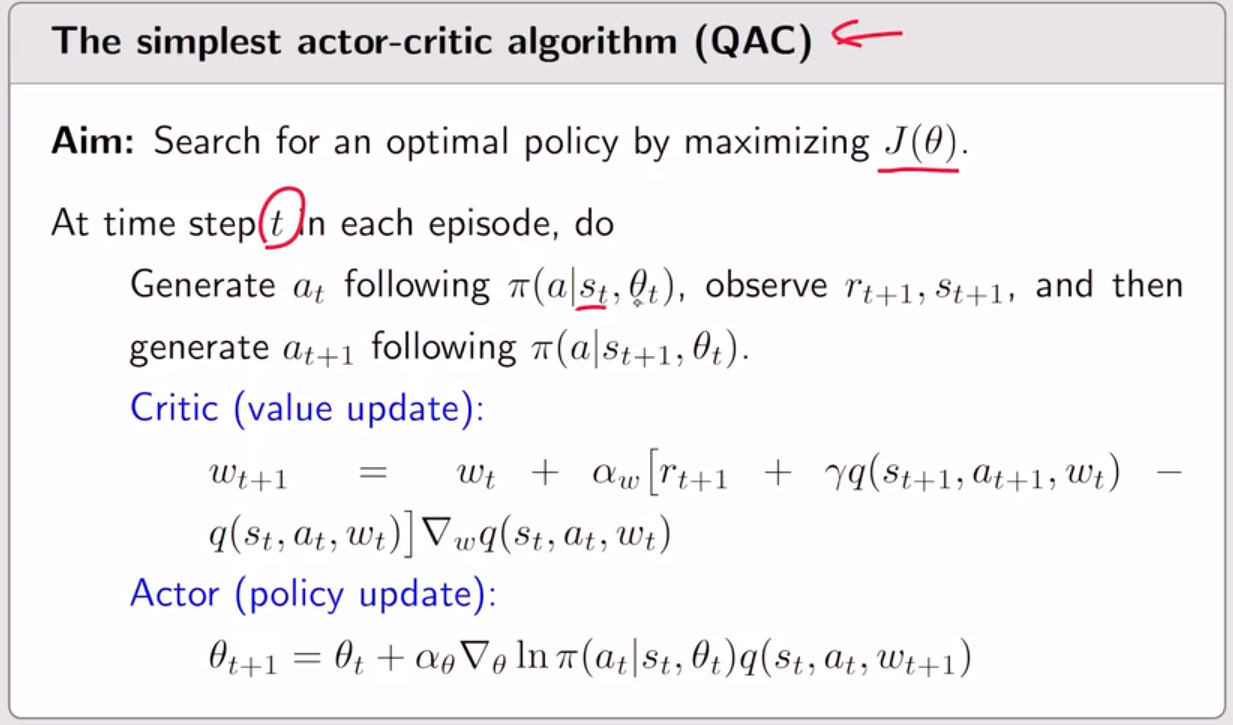

In [25]:
import gym
import matplotlib.pyplot as plt
import numpy as np
from math import cos, pi
import random
from itertools import product
from pprint import pprint

In [26]:
def evaluate_policy(env, agent):
    s_k, info = env.reset(seed=cfg_params["random_seed"])
    terminated = False
    sum_reward = 0
    for _ in range(cfg_params["max_episode_steps"]):
        a_k = agent.select_action(s_k)
        s_k1, r_k, terminated, _ , info = env.step(a_k)
#         print(f"s_k: {s_k}, a_k: {a_k}, s_k1: {s_k1}, r_k: {r_k}, terminated: {terminated}")
        sum_reward += r_k
        s_k = s_k1
        if terminated:
            break
    return sum_reward
    

In [27]:
class LinearModel():
    def __init__(self, q_num):
        self.q_num = q_num  # 这个参数很神奇，大了小了都会影响训练效率，相当于49个参数，比起表格4*16=64个，少了15个参数
        self.omega = np.zeros(self.q_num**2)
    
    def val(self, s_k, a_k):
        return np.dot(self.grad(s_k, a_k), self.omega) 
        
    def grad(self, s_k, a_k):
        # normalize
        normal_sk = s_k/15
        normal_ak = a_k/3
        
        return np.array([cos(pi*(x[0]*normal_sk + x[1]*normal_ak)) for x in list(product(range(self.q_num), repeat=2))])

    def pprint(self):
        pprint([[round(self.val(i, j),3) for j in range(4)] for i in range(16)])

class PolicyModel(LinearModel):
    def __init__(self, q_num):
        super().__init__(q_num)
    
    def val(self, s_k: int, a_k: int) -> float:
        '''use parameterize policy'''
        h_func = [np.dot(self.omega, self.grad(s_k, i)) for i in range(4)]    
        pp = self.softmax(h_func)
        return pp[int(a_k)]
    
    def softmax(self, x):
        x_exp = np.exp(x)
        # 如果是列向量，则axis=0
        x_sum = np.sum(x_exp, axis=0, keepdims=True)
        s = x_exp / x_sum
        return s

    
class QValueModel(LinearModel):
    def __init__(self, q_num):
        super().__init__(q_num)
    

In [28]:
class Agent():
    def __init__(self, action_dim: int, state_dim: int, alpha=0.01, gamma=0.9):
        self.action_dim = action_dim
        self.state_dim = state_dim
        self.alpha = alpha
        self.gamma = gamma

        self.policy = PolicyModel(5)
        self.Q = QValueModel(7)
    
    def select_action(self, s_k: int) -> int:
        return random.choices(range(4), weights=[self.policy.val(s_k, ak) for ak in range(4)])[0]
    
    def train(self, s_k, a_k, r_k, s_k1):
        # policy evaluation
        # target_Q = r_k + self.gamma * np.max([self.Q(s_k1, i) for i in range(4)]) # Q learning
        target_Q = r_k + self.gamma * self.Q.val(s_k1, self.select_action(s_k1))  # saras
        self.Q.omega += self.alpha * (target_Q - self.Q.val(s_k, a_k)) * self.Q.grad(s_k, a_k)
        
        # actor (policy update)
        delta_ln_policy = self.policy.grad(s_k, a_k) / self.policy.val(s_k, a_k)
        self.policy.omega += self.alpha * delta_ln_policy * self.Q.val(int(s_k), int(a_k))
        
        

In [29]:
# parameter
cfg_params = {
    "env_name" : "FrozenLake-v1",
    "random_seed": 0,
    "max_train_steps": 3000,
    "max_episode_steps": 500,
}

env = gym.make(cfg_params["env_name"], desc=None, map_name="4x4", is_slippery=False) #  gym.make("CliffWalking-v0", render_mode="human")


In [30]:
# make it as a funtion for data analysis

agent = Agent(
    action_dim=env.action_space.n,
    state_dim=env.observation_space.n,
    alpha=0.02,
    gamma=0.9)

# training
score_queue = []

for k in range(cfg_params["max_train_steps"]):
    # reset t  he s_k
    s_k, info = env.reset(seed=cfg_params["random_seed"])
    # collect data set
    for ek in range(cfg_params["max_episode_steps"]):
        a_k = agent.select_action(s_k)
        s_k1, r_k, terminated, truncated, info = env.step(a_k)
        agent.train(s_k, a_k, r_k, s_k1)
        if terminated:
#             print(f"s_k: {s_k}, s_k1: {s_k1}, r_k: {r_k}, a_k: {a_k}, e_k : {ek}, terminated: {terminated}")
            break
        s_k = s_k1

    score = evaluate_policy(env, agent)
    score_queue.append(score)
    print(f'current step: {k}/{cfg_params["max_train_steps"]}, score: {score}')


current step: 0/3000, score: 0.0
current step: 1/3000, score: 0.0
current step: 2/3000, score: 0.0
current step: 3/3000, score: 0.0
current step: 4/3000, score: 0.0
current step: 5/3000, score: 0.0
current step: 6/3000, score: 0.0
current step: 7/3000, score: 0.0
current step: 8/3000, score: 0.0
current step: 9/3000, score: 0.0
current step: 10/3000, score: 0.0
current step: 11/3000, score: 0.0
current step: 12/3000, score: 0.0
current step: 13/3000, score: 0.0
current step: 14/3000, score: 0.0
current step: 15/3000, score: 0.0
current step: 16/3000, score: 0.0
current step: 17/3000, score: 0.0
current step: 18/3000, score: 0.0
current step: 19/3000, score: 0.0
current step: 20/3000, score: 0.0
current step: 21/3000, score: 1.0
current step: 22/3000, score: 0.0
current step: 23/3000, score: 0.0
current step: 24/3000, score: 0.0
current step: 25/3000, score: 0.0
current step: 26/3000, score: 0.0
current step: 27/3000, score: 0.0
current step: 28/3000, score: 0.0
current step: 29/3000, s

current step: 248/3000, score: 0.0
current step: 249/3000, score: 0.0
current step: 250/3000, score: 0.0
current step: 251/3000, score: 0.0
current step: 252/3000, score: 0.0
current step: 253/3000, score: 0.0
current step: 254/3000, score: 0.0
current step: 255/3000, score: 0.0
current step: 256/3000, score: 0.0
current step: 257/3000, score: 0.0
current step: 258/3000, score: 0.0
current step: 259/3000, score: 0.0
current step: 260/3000, score: 0.0
current step: 261/3000, score: 0.0
current step: 262/3000, score: 0.0
current step: 263/3000, score: 0.0
current step: 264/3000, score: 0.0
current step: 265/3000, score: 0.0
current step: 266/3000, score: 0.0
current step: 267/3000, score: 0.0
current step: 268/3000, score: 0.0
current step: 269/3000, score: 0.0
current step: 270/3000, score: 0.0
current step: 271/3000, score: 0.0
current step: 272/3000, score: 0.0
current step: 273/3000, score: 0.0
current step: 274/3000, score: 0.0
current step: 275/3000, score: 0.0
current step: 276/30

current step: 494/3000, score: 0.0
current step: 495/3000, score: 0.0
current step: 496/3000, score: 0.0
current step: 497/3000, score: 0.0
current step: 498/3000, score: 0.0
current step: 499/3000, score: 0.0
current step: 500/3000, score: 0.0
current step: 501/3000, score: 0.0
current step: 502/3000, score: 0.0
current step: 503/3000, score: 0.0
current step: 504/3000, score: 0.0
current step: 505/3000, score: 0.0
current step: 506/3000, score: 0.0
current step: 507/3000, score: 0.0
current step: 508/3000, score: 0.0
current step: 509/3000, score: 0.0
current step: 510/3000, score: 0.0
current step: 511/3000, score: 0.0
current step: 512/3000, score: 0.0
current step: 513/3000, score: 0.0
current step: 514/3000, score: 0.0
current step: 515/3000, score: 0.0
current step: 516/3000, score: 0.0
current step: 517/3000, score: 0.0
current step: 518/3000, score: 0.0
current step: 519/3000, score: 0.0
current step: 520/3000, score: 0.0
current step: 521/3000, score: 0.0
current step: 522/30

current step: 729/3000, score: 0.0
current step: 730/3000, score: 0.0
current step: 731/3000, score: 0.0
current step: 732/3000, score: 0.0
current step: 733/3000, score: 0.0
current step: 734/3000, score: 0.0
current step: 735/3000, score: 0.0
current step: 736/3000, score: 0.0
current step: 737/3000, score: 0.0
current step: 738/3000, score: 0.0
current step: 739/3000, score: 0.0
current step: 740/3000, score: 0.0
current step: 741/3000, score: 0.0
current step: 742/3000, score: 0.0
current step: 743/3000, score: 0.0
current step: 744/3000, score: 0.0
current step: 745/3000, score: 0.0
current step: 746/3000, score: 0.0
current step: 747/3000, score: 0.0
current step: 748/3000, score: 0.0
current step: 749/3000, score: 0.0
current step: 750/3000, score: 0.0
current step: 751/3000, score: 0.0
current step: 752/3000, score: 0.0
current step: 753/3000, score: 0.0
current step: 754/3000, score: 0.0
current step: 755/3000, score: 0.0
current step: 756/3000, score: 0.0
current step: 757/30

current step: 986/3000, score: 0.0
current step: 987/3000, score: 0.0
current step: 988/3000, score: 0.0
current step: 989/3000, score: 0.0
current step: 990/3000, score: 0.0
current step: 991/3000, score: 0.0
current step: 992/3000, score: 0.0
current step: 993/3000, score: 0.0
current step: 994/3000, score: 0.0
current step: 995/3000, score: 0.0
current step: 996/3000, score: 0.0
current step: 997/3000, score: 0.0
current step: 998/3000, score: 0.0
current step: 999/3000, score: 0.0
current step: 1000/3000, score: 0.0
current step: 1001/3000, score: 0.0
current step: 1002/3000, score: 0.0
current step: 1003/3000, score: 0.0
current step: 1004/3000, score: 0.0
current step: 1005/3000, score: 0.0
current step: 1006/3000, score: 0.0
current step: 1007/3000, score: 0.0
current step: 1008/3000, score: 0.0
current step: 1009/3000, score: 0.0
current step: 1010/3000, score: 0.0
current step: 1011/3000, score: 0.0
current step: 1012/3000, score: 0.0
current step: 1013/3000, score: 0.0
curren

current step: 1217/3000, score: 0.0
current step: 1218/3000, score: 0.0
current step: 1219/3000, score: 0.0
current step: 1220/3000, score: 0.0
current step: 1221/3000, score: 0.0
current step: 1222/3000, score: 0.0
current step: 1223/3000, score: 0.0
current step: 1224/3000, score: 0.0
current step: 1225/3000, score: 0.0
current step: 1226/3000, score: 0.0
current step: 1227/3000, score: 0.0
current step: 1228/3000, score: 0.0
current step: 1229/3000, score: 0.0
current step: 1230/3000, score: 0.0
current step: 1231/3000, score: 0.0
current step: 1232/3000, score: 0.0
current step: 1233/3000, score: 0.0
current step: 1234/3000, score: 0.0
current step: 1235/3000, score: 0.0
current step: 1236/3000, score: 0.0
current step: 1237/3000, score: 0.0
current step: 1238/3000, score: 0.0
current step: 1239/3000, score: 0.0
current step: 1240/3000, score: 0.0
current step: 1241/3000, score: 0.0
current step: 1242/3000, score: 0.0
current step: 1243/3000, score: 0.0
current step: 1244/3000, sco

current step: 1462/3000, score: 0.0
current step: 1463/3000, score: 0.0
current step: 1464/3000, score: 0.0
current step: 1465/3000, score: 0.0
current step: 1466/3000, score: 0.0
current step: 1467/3000, score: 0.0
current step: 1468/3000, score: 0.0
current step: 1469/3000, score: 0.0
current step: 1470/3000, score: 0.0
current step: 1471/3000, score: 0.0
current step: 1472/3000, score: 0.0
current step: 1473/3000, score: 0.0
current step: 1474/3000, score: 0.0
current step: 1475/3000, score: 0.0
current step: 1476/3000, score: 0.0
current step: 1477/3000, score: 0.0
current step: 1478/3000, score: 0.0
current step: 1479/3000, score: 0.0
current step: 1480/3000, score: 0.0
current step: 1481/3000, score: 0.0
current step: 1482/3000, score: 0.0
current step: 1483/3000, score: 0.0
current step: 1484/3000, score: 0.0
current step: 1485/3000, score: 0.0
current step: 1486/3000, score: 0.0
current step: 1487/3000, score: 0.0
current step: 1488/3000, score: 0.0
current step: 1489/3000, sco

current step: 1693/3000, score: 0.0
current step: 1694/3000, score: 0.0
current step: 1695/3000, score: 0.0
current step: 1696/3000, score: 0.0
current step: 1697/3000, score: 0.0
current step: 1698/3000, score: 0.0
current step: 1699/3000, score: 0.0
current step: 1700/3000, score: 0.0
current step: 1701/3000, score: 0.0
current step: 1702/3000, score: 0.0
current step: 1703/3000, score: 0.0
current step: 1704/3000, score: 0.0
current step: 1705/3000, score: 0.0
current step: 1706/3000, score: 0.0
current step: 1707/3000, score: 0.0
current step: 1708/3000, score: 0.0
current step: 1709/3000, score: 0.0
current step: 1710/3000, score: 0.0
current step: 1711/3000, score: 0.0
current step: 1712/3000, score: 0.0
current step: 1713/3000, score: 0.0
current step: 1714/3000, score: 0.0
current step: 1715/3000, score: 0.0
current step: 1716/3000, score: 0.0
current step: 1717/3000, score: 0.0
current step: 1718/3000, score: 0.0
current step: 1719/3000, score: 0.0
current step: 1720/3000, sco

current step: 1940/3000, score: 0.0
current step: 1941/3000, score: 0.0
current step: 1942/3000, score: 0.0
current step: 1943/3000, score: 0.0
current step: 1944/3000, score: 0.0
current step: 1945/3000, score: 0.0
current step: 1946/3000, score: 0.0
current step: 1947/3000, score: 0.0
current step: 1948/3000, score: 0.0
current step: 1949/3000, score: 0.0
current step: 1950/3000, score: 0.0
current step: 1951/3000, score: 0.0
current step: 1952/3000, score: 0.0
current step: 1953/3000, score: 0.0
current step: 1954/3000, score: 0.0
current step: 1955/3000, score: 0.0
current step: 1956/3000, score: 0.0
current step: 1957/3000, score: 0.0
current step: 1958/3000, score: 0.0
current step: 1959/3000, score: 0.0
current step: 1960/3000, score: 0.0
current step: 1961/3000, score: 0.0
current step: 1962/3000, score: 0.0
current step: 1963/3000, score: 0.0
current step: 1964/3000, score: 0.0
current step: 1965/3000, score: 0.0
current step: 1966/3000, score: 0.0
current step: 1967/3000, sco

current step: 2192/3000, score: 0.0
current step: 2193/3000, score: 0.0
current step: 2194/3000, score: 0.0
current step: 2195/3000, score: 0.0
current step: 2196/3000, score: 0.0
current step: 2197/3000, score: 0.0
current step: 2198/3000, score: 0.0
current step: 2199/3000, score: 0.0
current step: 2200/3000, score: 0.0
current step: 2201/3000, score: 0.0
current step: 2202/3000, score: 0.0
current step: 2203/3000, score: 0.0
current step: 2204/3000, score: 0.0
current step: 2205/3000, score: 0.0
current step: 2206/3000, score: 0.0
current step: 2207/3000, score: 0.0
current step: 2208/3000, score: 0.0
current step: 2209/3000, score: 0.0
current step: 2210/3000, score: 0.0
current step: 2211/3000, score: 0.0
current step: 2212/3000, score: 0.0
current step: 2213/3000, score: 0.0
current step: 2214/3000, score: 0.0
current step: 2215/3000, score: 0.0
current step: 2216/3000, score: 0.0
current step: 2217/3000, score: 0.0
current step: 2218/3000, score: 0.0
current step: 2219/3000, sco

current step: 2439/3000, score: 0.0
current step: 2440/3000, score: 0.0
current step: 2441/3000, score: 0.0
current step: 2442/3000, score: 0.0
current step: 2443/3000, score: 0.0
current step: 2444/3000, score: 0.0
current step: 2445/3000, score: 0.0
current step: 2446/3000, score: 0.0
current step: 2447/3000, score: 0.0
current step: 2448/3000, score: 0.0
current step: 2449/3000, score: 0.0
current step: 2450/3000, score: 0.0
current step: 2451/3000, score: 0.0
current step: 2452/3000, score: 0.0
current step: 2453/3000, score: 0.0
current step: 2454/3000, score: 0.0
current step: 2455/3000, score: 0.0
current step: 2456/3000, score: 0.0
current step: 2457/3000, score: 0.0
current step: 2458/3000, score: 0.0
current step: 2459/3000, score: 0.0
current step: 2460/3000, score: 0.0
current step: 2461/3000, score: 0.0
current step: 2462/3000, score: 0.0
current step: 2463/3000, score: 0.0
current step: 2464/3000, score: 0.0
current step: 2465/3000, score: 0.0
current step: 2466/3000, sco

current step: 2671/3000, score: 0.0
current step: 2672/3000, score: 0.0
current step: 2673/3000, score: 0.0
current step: 2674/3000, score: 0.0
current step: 2675/3000, score: 0.0
current step: 2676/3000, score: 0.0
current step: 2677/3000, score: 0.0
current step: 2678/3000, score: 0.0
current step: 2679/3000, score: 0.0
current step: 2680/3000, score: 0.0
current step: 2681/3000, score: 0.0
current step: 2682/3000, score: 0.0
current step: 2683/3000, score: 0.0
current step: 2684/3000, score: 0.0
current step: 2685/3000, score: 0.0
current step: 2686/3000, score: 0.0
current step: 2687/3000, score: 0.0
current step: 2688/3000, score: 0.0
current step: 2689/3000, score: 0.0
current step: 2690/3000, score: 0.0
current step: 2691/3000, score: 0.0
current step: 2692/3000, score: 0.0
current step: 2693/3000, score: 0.0
current step: 2694/3000, score: 0.0
current step: 2695/3000, score: 0.0
current step: 2696/3000, score: 0.0
current step: 2697/3000, score: 0.0
current step: 2698/3000, sco

current step: 2901/3000, score: 0.0
current step: 2902/3000, score: 0.0
current step: 2903/3000, score: 0.0
current step: 2904/3000, score: 0.0
current step: 2905/3000, score: 0.0
current step: 2906/3000, score: 0.0
current step: 2907/3000, score: 0.0
current step: 2908/3000, score: 0.0
current step: 2909/3000, score: 0.0
current step: 2910/3000, score: 0.0
current step: 2911/3000, score: 0.0
current step: 2912/3000, score: 0.0
current step: 2913/3000, score: 0.0
current step: 2914/3000, score: 0.0
current step: 2915/3000, score: 0.0
current step: 2916/3000, score: 0.0
current step: 2917/3000, score: 0.0
current step: 2918/3000, score: 0.0
current step: 2919/3000, score: 0.0
current step: 2920/3000, score: 0.0
current step: 2921/3000, score: 0.0
current step: 2922/3000, score: 0.0
current step: 2923/3000, score: 0.0
current step: 2924/3000, score: 0.0
current step: 2925/3000, score: 0.0
current step: 2926/3000, score: 0.0
current step: 2927/3000, score: 0.0
current step: 2928/3000, sco

In [31]:
agent.Q.pprint()

[[0.003, 0.016, 0.001, 0.011],
 [0.001, 0.005, -0.003, 0.008],
 [-0.0, -0.001, -0.009, 0.004],
 [0.004, 0.009, 0.004, 0.003],
 [0.014, 0.019, 0.017, 0.007],
 [0.019, 0.007, 0.008, 0.011],
 [0.018, -0.018, -0.011, 0.012],
 [0.02, -0.019, -0.005, 0.014],
 [0.028, 0.022, 0.024, 0.019],
 [0.034, 0.072, 0.033, 0.021],
 [0.027, 0.088, 0.01, 0.014],
 [0.015, 0.067, 0.02, 0.006],
 [0.024, 0.053, 0.138, 0.013],
 [0.066, 0.08, 0.337, 0.045],
 [0.12, 0.127, 0.468, 0.085],
 [0.145, 0.139, 0.409, 0.103]]


In [32]:
agent.policy.pprint()

[[0.0, 0.112, 0.0, 0.888],
 [0.0, 0.993, 0.0, 0.007],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.625, 0.088, 0.287, 0.0],
 [1.0, 0.0, 0.0, 0.0],
 [0.015, 0.985, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.573, 0.426, 0.001, 0.0],
 [0.954, 0.04, 0.006, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0]]


In [13]:
evaluate_env = gym.make(cfg_params["env_name"], render_mode="human",desc=None, map_name="4x4", is_slippery=False)
evaluate_policy(evaluate_env, agent)

0.0